<a href="https://colab.research.google.com/github/vaish1062004/tomato-leaf-disease-detection/blob/main/leaf_disease_with_xai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 64
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=15

In [3]:
import zipfile

# Path to your zip file
zip_path = '/content/leaf.zip'

# Directory where you want to extract the files
extract_path = '/content/extracted_data/'

# Open the zip file and extract its contents
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to {extract_path}")

Files extracted to /content/extracted_data/


In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/extracted_data/leaf",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3000 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy']

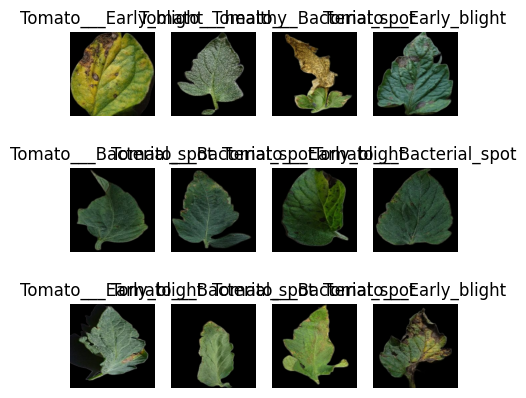

In [6]:
plt.figure(figsize=(5, 5))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

In [75]:
# 1. Define the input tensor
inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

# 2. Define the data flow (Preprocessing layers)
x = layers.Resizing(IMAGE_SIZE, IMAGE_SIZE)(inputs)
x = layers.Rescaling(1./255)(x)

# 3. Convolutional layers
x = layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
# Explicitly NAME the last Conv2D layer for easy Grad-CAM access
x = layers.Conv2D(64, (3, 3), activation='relu', name='last_conv_layer')(x)
x = layers.MaxPooling2D((2, 2))(x)

# 4. Dense layers
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(n_classes, activation='softmax')(x)

# 5. Create the final Model object
model = models.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_2 (Resizing)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_conv_layer (Conv2D)        │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [76]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_2 (Resizing)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_conv_layer (Conv2D)        │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [77]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [78]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=15,
)

Epoch 1/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 190ms/step - accuracy: 0.3746 - loss: 1.0436 - val_accuracy: 0.7812 - val_loss: 0.5336
Epoch 2/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.7968 - loss: 0.5121 - val_accuracy: 0.8555 - val_loss: 0.3086
Epoch 3/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.8452 - loss: 0.3749 - val_accuracy: 0.9062 - val_loss: 0.2519
Epoch 4/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.8926 - loss: 0.2592 - val_accuracy: 0.8984 - val_loss: 0.3184
Epoch 5/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.8865 - loss: 0.2987 - val_accuracy: 0.9453 - val_loss: 0.1607
Epoch 6/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.9162 - loss: 0.2251 - val_accuracy: 0.9570 - val_loss: 0.1202
Epoch 7/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.9320 - loss: 0.1848 - val_accuracy: 0.9609 - val_loss: 0.1056
Epoch 8/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.9423 - loss: 0.1470 - val_accuracy: 0

In [79]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

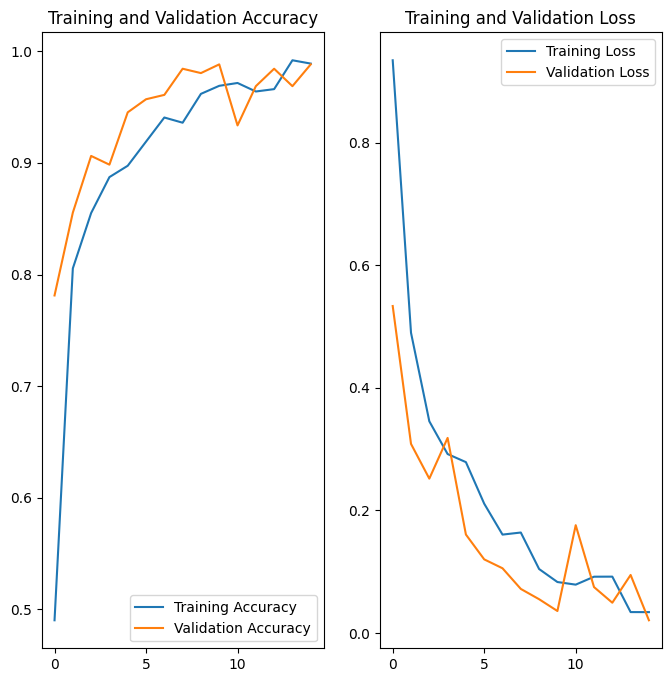

In [80]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Tomato___healthy
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step 
predicted label: Tomato___healthy


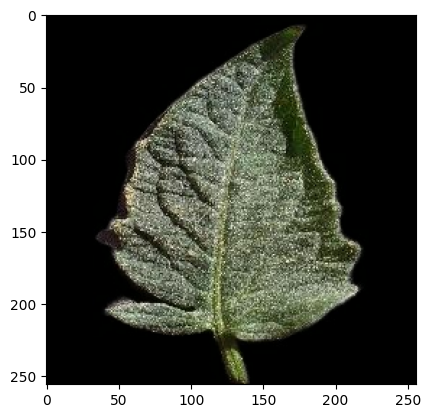

In [81]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [82]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


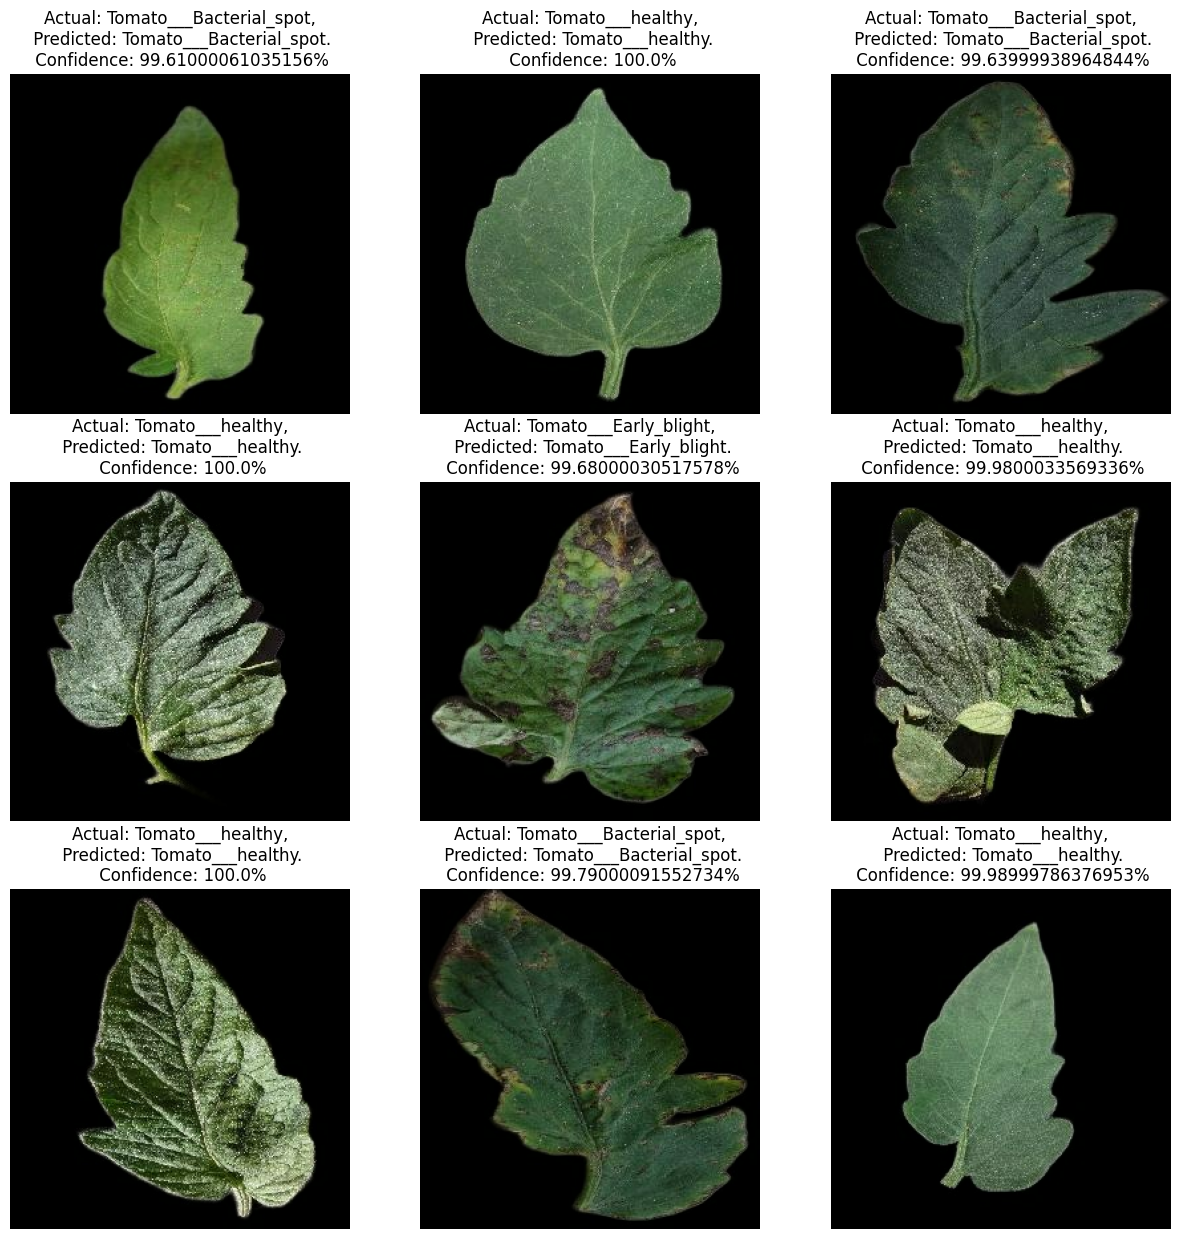

In [86]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

Using last conv layer: last_conv_layer
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted class: Tomato___Bacterial_spot (Confidence: 1.00)


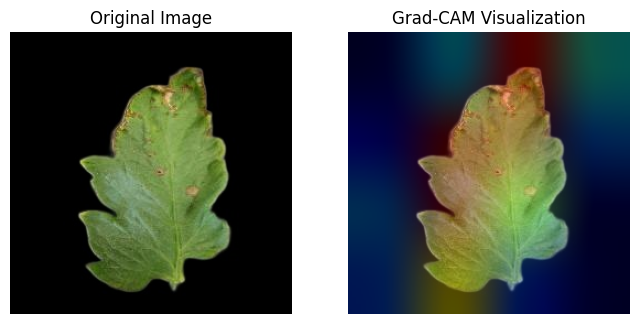

In [94]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# --- GRAD-CAM FUNCTIONS ---

def get_img_array(img_path, size):
    """
    Prepares a single image for model prediction.
    """
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # Add a batch dimension
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Generates the Grad-CAM heatmap.
    """
    # Create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute the gradient
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            # Get the top prediction index
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Gradient of the top predicted class with respect to the output feature map
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array by its importance
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # ReLU to filter out negative values
    heatmap = tf.maximum(heatmap, 0)

    # Normalize heatmap (Fixed to prevent division by zero warning)
    epsilon = tf.constant(1e-8)
    heatmap = heatmap / (tf.math.reduce_max(heatmap) + epsilon)

    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4):
    """
    Superimposes the heatmap on the original image.
    """
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Convert BGR (OpenCV format) to RGB
    jet = cv2.cvtColor(jet, cv2.COLOR_BGR2RGB)

    # Superimpose the heatmap on original image
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Display Grad-CAM
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(tf.keras.preprocessing.image.load_img(img_path))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title("Grad-CAM Visualization")
    plt.axis('off')

    plt.show()

# --- IMPLEMENTATION ---

# 1. SET THE PATH TO YOUR TEST IMAGE
# Ensure this path is correct for your environment
img_path = "/content/extracted_data/leaf/Tomato___Bacterial_spot/07246956-b38c-4d28-acec-85d032ba989e___UF.GRC_BS_Lab Leaf 0278.JPG"

# 2. PREPARE THE IMAGE
# IMAGE_SIZE should be defined earlier (e.g., 256)
img_array = get_img_array(img_path, size=(IMAGE_SIZE, IMAGE_SIZE))

# 3. SET THE NAME OF THE LAST CONV LAYER (Explicit name from the Functional API)
last_conv_layer_name = "last_conv_layer"
print(f"Using last conv layer: {last_conv_layer_name}")

# 4. MAKE PREDICTION (to find the top predicted class)
preds = model.predict(img_array)
top_pred_index = np.argmax(preds[0])
print(f"Predicted class: {class_names[top_pred_index]} (Confidence: {preds[0][top_pred_index]:.2f})")

# 5. GENERATE AND DISPLAY THE HEATMAP
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=top_pred_index)

# 6. DISPLAY THE SUPERIMPOSED IMAGE
display_gradcam(img_path, heatmap)